In [0]:
!pip install -q xlrd
!git clone https://github.com/awrou/CS109A_FinalProject.git
!pip install imageio

Cloning into 'CS109A_FinalProject'...
remote: Enumerating objects: 41471, done.
remote: Counting objects: 100% (41471/41471), done.
remote: Compressing objects: 100% (21145/21145), done.
remote: Total 41471 (delta 20311), reused 41470 (delta 20310), pack-reused 0
Receiving objects: 100% (41471/41471), 775.33 MiB | 14.50 MiB/s, done.
Resolving deltas: 100% (20311/20311), done.
Checking out files: 100% (41169/41169), done.


In [0]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 19.5MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.io import loadmat
from IPython.display import display
from tqdm import tqdm
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
from keras.applications.vgg19 import VGG19
from keras import models
from keras import layers

import re
import os
import imageio
import cv2
import keras



In [0]:
os.chdir('CS109A_FinalProject/')

## 1. Introduction




### 1.1 Description of Data



This project is an attempt to accurately identify dog breeds from a dataset containing 120 different breeds.  This problem is a particularly challenging task for at least three reasons:


1.   The dataset provided is part of the Stanford Dog's Dataset, which contains 20,000 images of dogs from 120 breeds, amounting to 200 images per breed.  Because this dataset will need to be split into a training and test set, the final training dataset used in this project contains only 120 dogs per breed.  This means that Convolutional Neural Nets (CNN), which are the standard tool for image classification, will have a difficult time given such a small amount of training data.  The solution to small amounts of training data is to either combine the dataset was images of dogs from other datasets, utilize image augmentation strategies, or use a neural net pretrained on larger sets of image data (e.g. ImageNet), and fine tune that net for our purposes.  In the current project, we use the latter two approaches. 

2.   All dog breeds share very similar physical characteristics and features.  Specifically, there is higher variation within breeds than between them on features such as size, shape, and color.  This inter-breed diversity makes it very difficult to pick up on the idiosyncratic characteristics that differentiate between dog breeds without accidentally overfitting on some characterstic of the training set. 

3. The images themselves are highly irregular -- some of them contain watermarks, some of them contain images of multiple dogs, some of them are in greyscale, while others are in sepia tone.  Discovering distinguishing features of dogs in light of all this noise will prove to be a challenging roblem.  


### 1.2 Motivation

Our goal was to more deeply understand the value of convolutional neural nets, exploring state-of-the-art architectures and techniques for extracting the maximum performance on image classification tasks.  

The paper accompanying the Stanford Dog dataset purports to achieve an accuracy of around 22% on the test set.  Given that this dataset was released in 2011, we expected to be able to get a similar, if not better performance, by fine-tuning state-of-the-art models.  

![alt text](http://vision.stanford.edu/aditya86/ImageNetDogs/mean_accuracy.png)

We were particularly interested in this task, because it seems to be a harder version of standard classification tasks (like Dog vs. Cat) in that there are many more categories of possible outputs (120 breeds) and many of those outputs share a huge amount of characteristics.  For example, Silky Terriers and Yorkshire Terriers look nearly identical to the human eyes.  We were interested in seeing if a well-trained CNN had similar difficulties in distinguishing those breeds. 

## 2. Loading Training and Test Data

**First we load in meta-data from the Stanford Image Dataset.   The contents of this dataset include the following:**


* **Number of categories:** 120 breeds
* **Number of images:** 20,580 distinct images of dogs
* **Annotations:**
   * **Class labels**:  A numerical factor between 1-120, indicating which breed of dog a given animal corresponds to. 
   * **Bounding boxes:** The x, y, height, and width coordinates demarcating a specific dog. 

The [Stanford website](http://vision.stanford.edu/aditya86/ImageNetDogs/) further explains the exact structure of the data, which is necessary for understanding the below code:

>>File Information:
 - images/
    -- Images of different breeds are in separate folders
 - annotations/
    -- Bounding box annotations of images
 - file_list.mat
    -- List of all files in the dataset
 - train_list.mat
    -- List and labels of all training images in dataset
 - test_list.mat
    -- List and labels of all test images in dataset

>>Train splits:
 In order to test with fewer than 100 images per class, the first
 n indices for each class in train_list.mat were used, where n is
 the number of training images per class.










In [0]:
# Load pre-constructed train/test arrays from Stanford Dataset
train_list = loadmat('./lists/train_list.mat')
test_list = loadmat('./lists/test_list.mat')

In [0]:
# Split training data into a directory list, label list, and annotation list
file_list_train = [i.item() for i in train_list["file_list"].flatten()]
label_list_train = [i.item() for i in train_list["labels"].flatten()]
annotation_list_train = [i.item() for i in train_list['annotation_list'].flatten()]

# Split testing data into a directory list, label list, and annotation list
file_list_test = [i.item() for i in test_list["file_list"].flatten()]
label_list_test = [i.item() for i in test_list["labels"].flatten()]
annotation_list_test = [i.item() for i in test_list['annotation_list'].flatten()]

In [0]:
# Examine contents of lists
print(file_list_train[0], "|", label_list_train[0], "|", annotation_list_train[0])

n02085620-Chihuahua/n02085620_5927.jpg | 1 | n02085620-Chihuahua/n02085620_5927


In [0]:
# Build a function to extract the breed name from the file list
def extract_breed(file_string):
    return re.search(r'\-(.*?)\/',file_string).group(1)

# Function to extract the breed name and clean string
def clean_breed(file_string):    
    breed = re.search(r'\-(.*?)\/',file_string).group(1)
    breed = breed.replace("_", " ")
    breed = breed.title()
    
    return(breed)

In [0]:
# Build DataFrames containing directory structure, name of breed, and label
breed_list_train = [clean_breed(i) for i in file_list_train]
breed_list_test = [clean_breed(i) for i in file_list_test]


train_df = pd.DataFrame(
    list(zip(file_list_train, annotation_list_train, breed_list_train, label_list_train)),
    columns=['File', 'Annotation', 'Breed', 'Label'])

test_df = pd.DataFrame(
    list(zip(file_list_test, annotation_list_test, breed_list_test, label_list_test)),
    columns=['File', 'Annotation', 'Breed', 'Label'])


#df_y_train = pd.get_dummies(pd.get_dummies(train.Label))

In [0]:
train_df.head()

File  \
0   n02085620-Chihuahua/n02085620_5927.jpg   
1   n02085620-Chihuahua/n02085620_4441.jpg   
2   n02085620-Chihuahua/n02085620_1502.jpg   
3   n02085620-Chihuahua/n02085620_1916.jpg   
4  n02085620-Chihuahua/n02085620_13151.jpg   

                            Annotation      Breed  Label  
0   n02085620-Chihuahua/n02085620_5927  Chihuahua      1  
1   n02085620-Chihuahua/n02085620_4441  Chihuahua      1  
2   n02085620-Chihuahua/n02085620_1502  Chihuahua      1  
3   n02085620-Chihuahua/n02085620_1916  Chihuahua      1  
4  n02085620-Chihuahua/n02085620_13151  Chihuahua      1

In [0]:
test_df.head()

File                          Annotation  \
0  n02085620-Chihuahua/n02085620_2650.jpg  n02085620-Chihuahua/n02085620_2650   
1  n02085620-Chihuahua/n02085620_4919.jpg  n02085620-Chihuahua/n02085620_4919   
2  n02085620-Chihuahua/n02085620_1765.jpg  n02085620-Chihuahua/n02085620_1765   
3  n02085620-Chihuahua/n02085620_3006.jpg  n02085620-Chihuahua/n02085620_3006   
4  n02085620-Chihuahua/n02085620_1492.jpg  n02085620-Chihuahua/n02085620_1492   

       Breed  Label  
0  Chihuahua      1  
1  Chihuahua      1  
2  Chihuahua      1  
3  Chihuahua      1  
4  Chihuahua      1

**Comments:**

*   The Stanford dataset comes with a matrix of file references to specific images.  It includes data on which breed each image is (a label that ranges from 1-120; so 120 breeds in total).  We load these file references, the breed, and the categorical label into a dataframe from ease of use.

*   We use a RegEx query to extract the name of the dog breed from each file reference

## 3. Examine Image Dimensions



Next, we read in each of the image files using the `imageio` library, and extract the shape of the file.  We store this shape data in `train_df` and `test_df`, which are the Pandas dataframes storing all meta-data relevant to referencing the directory of specific dog images.  

We then display images in the training and test set by their height and width dimensions, which will help inform our approach to re-sizing and potentially removing some images from the training set. 

In [0]:
%%time

# Create a blank list to store the dimensions of each image in training dataset
# Takes a considerable amount of time
# Don't re-run unless you have to

image_height = []
image_width = []

for index, value in train_df.iterrows():
    height, width, _ = imageio.imread("Images/" + train_df.iloc[index].File).shape
    image_height.append(height)
    image_width.append(width)

CPU times: user 50.9 s, sys: 979 ms, total: 51.8 s
Wall time: 51.9 s


In [0]:
%%time

# Create a blank list to store the dimensions of each image in test dataset
# Takes a considerable amount of time

image_height_test = []
image_width_test = []

for index, value in test_df.iterrows():
    height, width, _  = imageio.imread("Images/" + test_df.iloc[index].File).shape
    image_height_test.append(height)
    image_width_test.append(width)

CPU times: user 36.2 s, sys: 641 ms, total: 36.8 s
Wall time: 36.8 s


In [0]:
#Create a Dimensions, Height and Width column for future use 
test_df['Height'] = image_height_test
test_df['Width'] = image_width_test

train_df['Height'] = image_height
train_df['Width'] = image_width

In [0]:
train_df.head()

File  \
0   n02085620-Chihuahua/n02085620_5927.jpg   
1   n02085620-Chihuahua/n02085620_4441.jpg   
2   n02085620-Chihuahua/n02085620_1502.jpg   
3   n02085620-Chihuahua/n02085620_1916.jpg   
4  n02085620-Chihuahua/n02085620_13151.jpg   

                            Annotation      Breed  Label  Height  Width  
0   n02085620-Chihuahua/n02085620_5927  Chihuahua      1     300    360  
1   n02085620-Chihuahua/n02085620_4441  Chihuahua      1     500    375  
2   n02085620-Chihuahua/n02085620_1502  Chihuahua      1     333    500  
3   n02085620-Chihuahua/n02085620_1916  Chihuahua      1     495    500  
4  n02085620-Chihuahua/n02085620_13151  Chihuahua      1     336    500

In [0]:
test_df.head()

File                          Annotation  \
0  n02085620-Chihuahua/n02085620_2650.jpg  n02085620-Chihuahua/n02085620_2650   
1  n02085620-Chihuahua/n02085620_4919.jpg  n02085620-Chihuahua/n02085620_4919   
2  n02085620-Chihuahua/n02085620_1765.jpg  n02085620-Chihuahua/n02085620_1765   
3  n02085620-Chihuahua/n02085620_3006.jpg  n02085620-Chihuahua/n02085620_3006   
4  n02085620-Chihuahua/n02085620_1492.jpg  n02085620-Chihuahua/n02085620_1492   

       Breed  Label  Height  Width  
0  Chihuahua      1     333    500  
1  Chihuahua      1     206    240  
2  Chihuahua      1     500    391  
3  Chihuahua      1     500    369  
4  Chihuahua      1     333    500

Text(0.5,0,'Width Dimension')

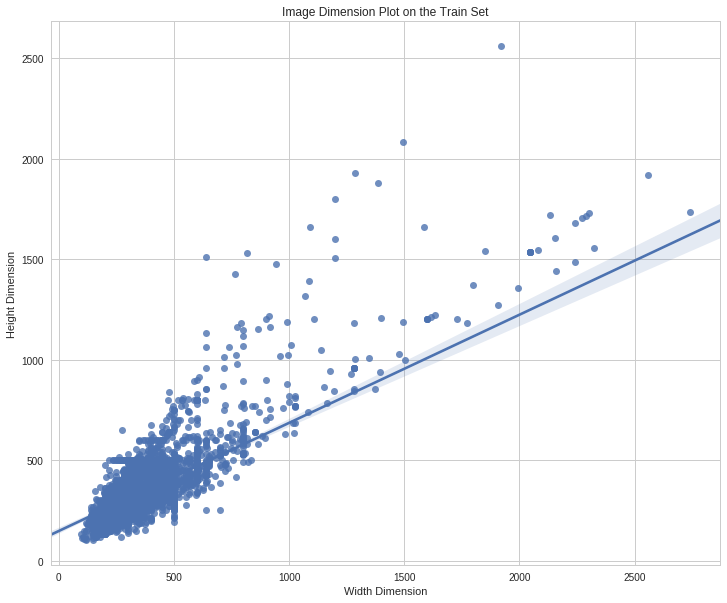

In [0]:
# Plot the Image Dimensions on the Train Set

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.regplot(x="Width", y="Height", data=train_df)
ax.set_title('Image Dimension Plot on the Train Set')
ax.set_ylabel('Height Dimension')
ax.set_xlabel('Width Dimension')

Text(0.5,0,'Width Dimension')

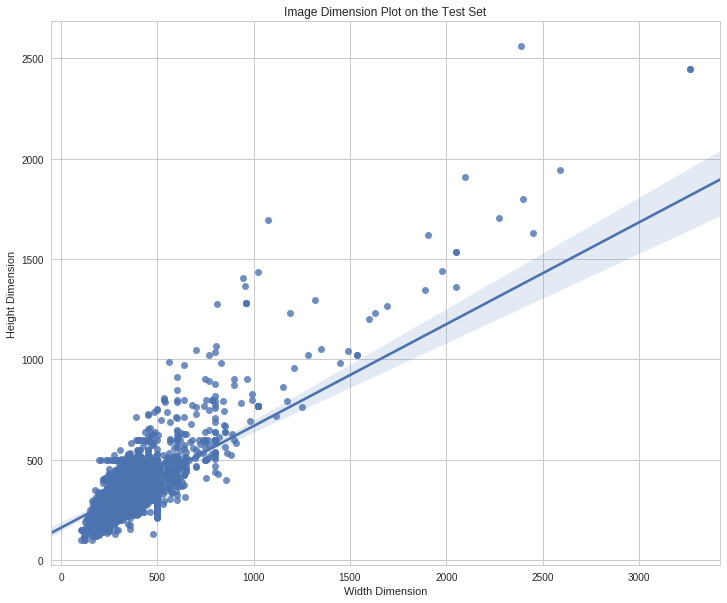

In [0]:
# Plot the Image Dimensions on the Test Set

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.regplot(x="Width", y="Height", data=test_df)
ax.set_title('Image Dimension Plot on the Test Set')
ax.set_ylabel('Height Dimension')
ax.set_xlabel('Width Dimension')

**Comments: **

*   We see that the majority of images are clustered at around 250 pixels by 250 pixels, with a few images reaching as large as 2500 x 2000 pixels.  The large variation in image size is unfortunate, as we will have to re-size the images for use in a CNN (recall that such image resizing is not necessary for a fully-connected network, but it is for a CNN).  It'll be difficult to avoid warping images, forcing some to be squeezed, and others to be stretched.

*   Other ML researchers who, when faced with a similar issue of large variation in image size, have thrown out any images that are not within some pre-defined distance of the re-sizing dimensions (to avoid over-warping).  Unfortunately, we do not have this luxury are there are precious few observations. 





## 4. Examine Distribution of Dog Breeds

Next, we plot the distribution of dog breeds in the training and test set.  We expect the training set to contain an equal number of dog breeds (such that a classifier cannot  do well by merely by predicting an over-represented class, and so that the classifier has an equal chance of learning crucial features from each dog breed),.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


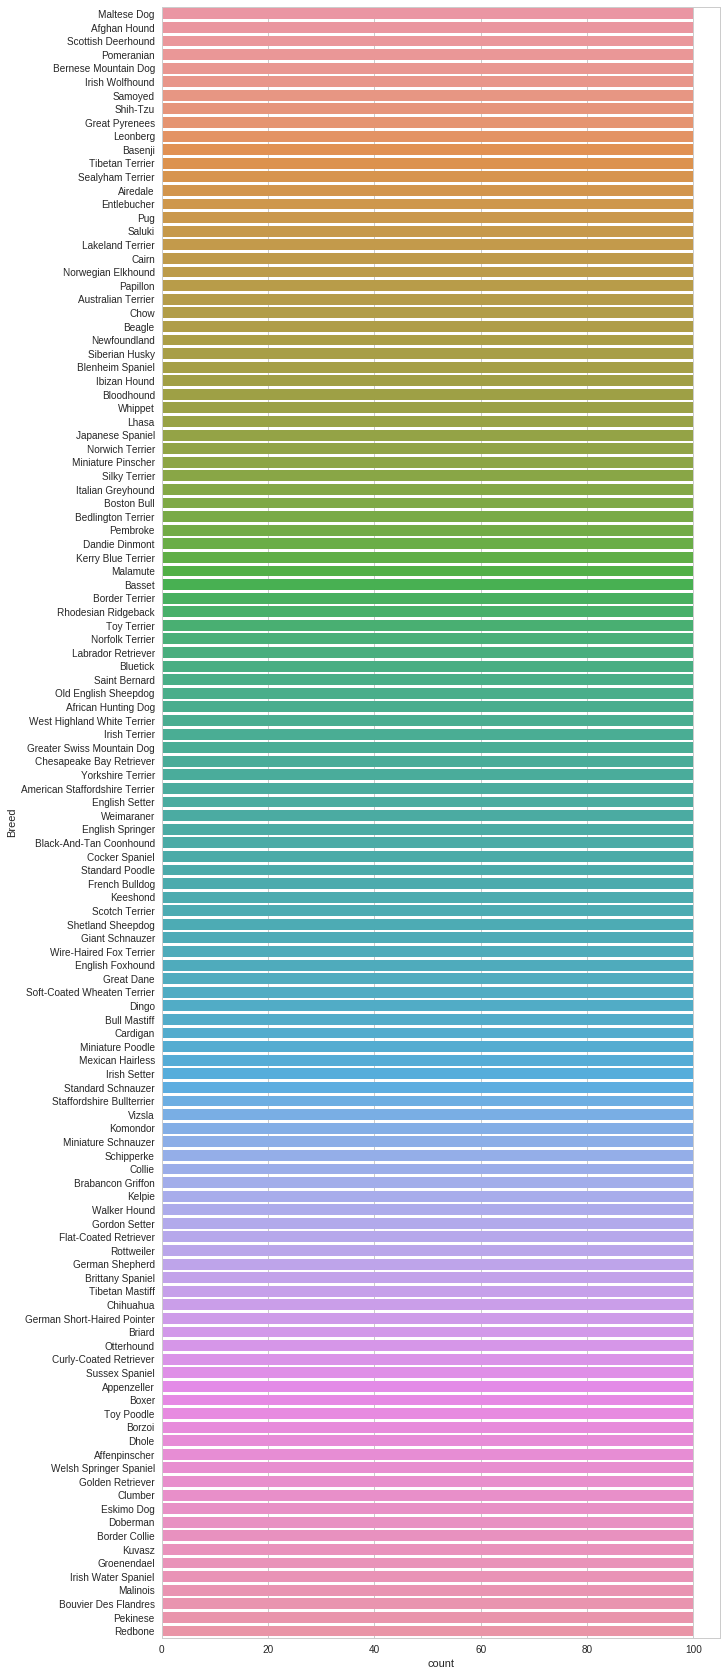

In [0]:
#Plot the breakdown of breeds in the training set
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 30))
ax = sns.countplot(y="Breed", data=train_df,
                   order = test_df['Breed'].value_counts().index)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


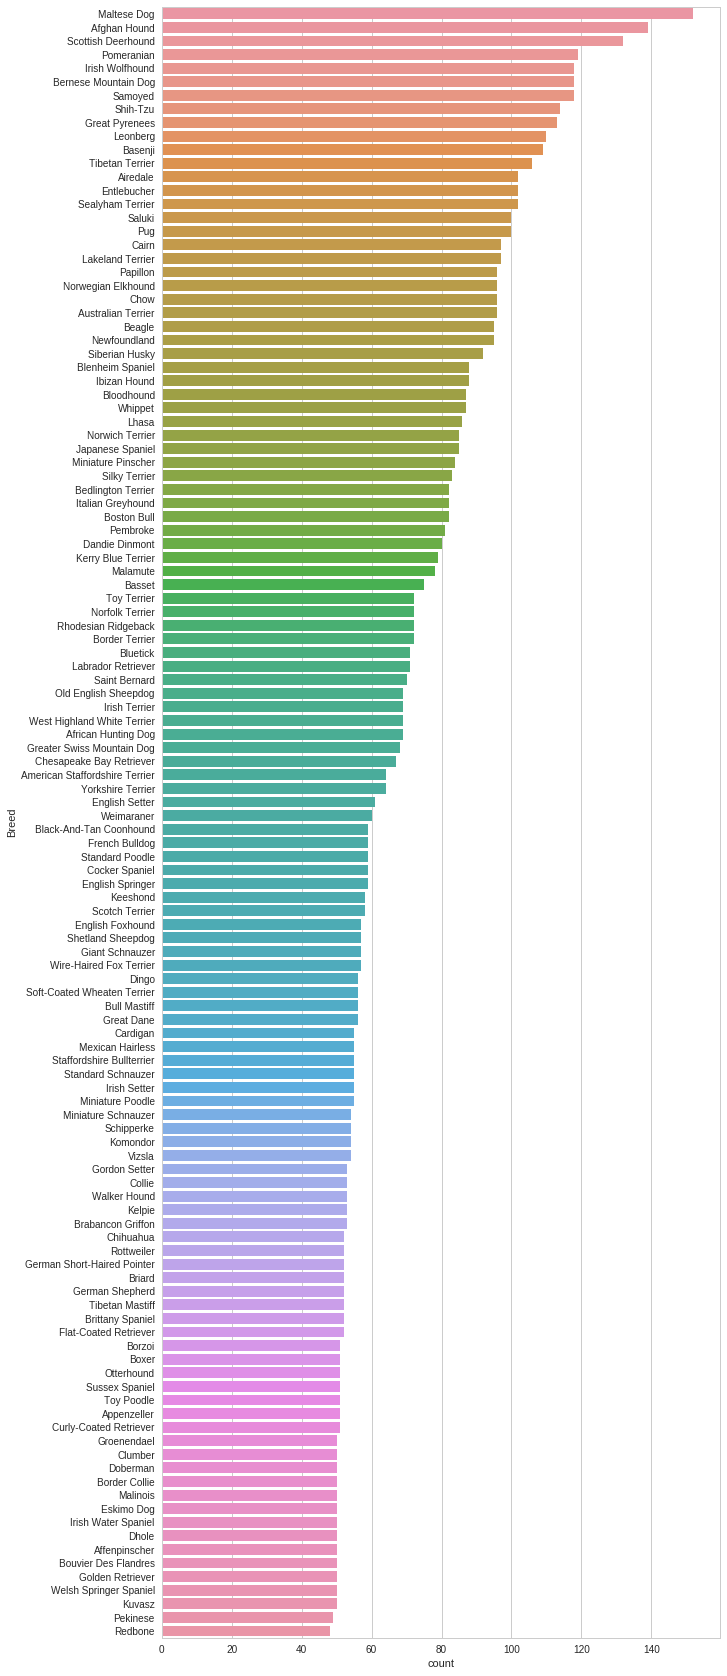

In [0]:
#Plot the breakdown of breeds in the test set
fig, ax = plt.subplots(figsize=(10, 30))
ax = sns.countplot(y="Breed", data=test_df, 
                   order = test_df['Breed'].value_counts().index)

**Comments:**

* We see that the training set contains 120 breeds of dogs, evenly distributed, with 100 example images per breed, for a total of 12,000 images in total.  In Deep Learning contexts, this is an extremely small dataset, so we should expect low levels of accuracy on the overall model with a naive CNN.  

* We see that the test set contains an uneven distribution of dog breeds.  

Next, we create a function that generate a bounding box around each dog image by identifying specific XML tags embedded in the Annotations file for each image.  This bounding box is used to both visualize the image of interest, and also as a guide for cropping the dog image later in the project. 

In [0]:
#Generates a bounding box of the image of the dog from the Annotations list
def generate_bounding_box(file_string):
    file = open(file_string, 'r', encoding="utf-8")
    file_content=file.readlines() 

    x_min = float(re.search(r'<xmin>(.+?)</xmin>', file_content[18]).group(1))
    y_min = float(re.search(r'<ymin>(.+?)</ymin>', file_content[19]).group(1))
    x_max = float(re.search(r'<xmax>(.+?)</xmax>', file_content[20]).group(1))
    y_max = float(re.search(r'<ymax>(.+?)</ymax>', file_content[21]).group(1))  
    
    box_height = y_max - y_min  
    box_width = x_max - x_min
          
    #bounding_box = f"{x_min}, {y_min}, {box_width}, {box_height}"
    bounding_box = [x_min, y_min, box_width, box_height]

    return(bounding_box)     

In [0]:
# Add bounding box data to the training set and test dataset
# Very slow to iterate over a dataframe and read in files 
%time

train_df['bounding_box'] = ""
test_df['bounding_box'] = ""

for index, breed in tqdm(train_df.iterrows()):
    train_df['bounding_box'][index] = generate_bounding_box("Annotation/" + train_df['Annotation'][index])
    
for index, breed in tqdm(test_df.iterrows()):
    test_df['bounding_box'][index] = generate_bounding_box("Annotation/" + test_df['Annotation'][index])
    

In [0]:
#we see the bounding box column has successfully been generated
display(train_df.head())
display(test_df.head())

File  \
0   n02085620-Chihuahua/n02085620_5927.jpg   
1   n02085620-Chihuahua/n02085620_4441.jpg   
2   n02085620-Chihuahua/n02085620_1502.jpg   
3   n02085620-Chihuahua/n02085620_1916.jpg   
4  n02085620-Chihuahua/n02085620_13151.jpg   

                            Annotation      Breed  Label  Height  Width  \
0   n02085620-Chihuahua/n02085620_5927  Chihuahua      1     300    360   
1   n02085620-Chihuahua/n02085620_4441  Chihuahua      1     500    375   
2   n02085620-Chihuahua/n02085620_1502  Chihuahua      1     333    500   
3   n02085620-Chihuahua/n02085620_1916  Chihuahua      1     495    500   
4  n02085620-Chihuahua/n02085620_13151  Chihuahua      1     336    500   

                   bounding_box  
0    [30.0, 14.0, 206.0, 284.0]  
1  [107.0, 110.0, 189.0, 291.0]  
2    [51.0, 13.0, 367.0, 318.0]  
3      [8.0, 7.0, 448.0, 390.0]  
4   [176.0, 29.0, 203.0, 304.0]

File                          Annotation  \
0  n02085620-Chihuahua/n02085620_2650.jpg  n02085620-Chihuahua/n02085620_2650   
1  n02085620-Chihuahua/n02085620_4919.jpg  n02085620-Chihuahua/n02085620_4919   
2  n02085620-Chihuahua/n02085620_1765.jpg  n02085620-Chihuahua/n02085620_1765   
3  n02085620-Chihuahua/n02085620_3006.jpg  n02085620-Chihuahua/n02085620_3006   
4  n02085620-Chihuahua/n02085620_1492.jpg  n02085620-Chihuahua/n02085620_1492   

       Breed  Label  Height  Width                 bounding_box  
0  Chihuahua      1     333    500  [108.0, 87.0, 297.0, 216.0]  
1  Chihuahua      1     206    240   [10.0, 22.0, 170.0, 183.0]  
2  Chihuahua      1     500    391   [55.0, 85.0, 272.0, 352.0]  
3  Chihuahua      1     500    369   [86.0, 42.0, 270.0, 450.0]  
4  Chihuahua      1     333    500  [58.0, 143.0, 132.0, 189.0]

## 5. Pickling and Unpickling the Data 

Because this data analysis was done in a Google Colab notebook, which limits the total amount of RAM and GPU time that can be used before crashing one's notebook... it is necessary to adopt good practices with respect to data preservation.  Here, we show the technique for saving a pickled version of the dataframe to one's Google Drive, and later recalling it when the Google notebook crashes.  If running the analysis for the first time, it is good to just start here to skip the time-intensive pre-processing steps.  

In [0]:
# Pickle the files to read in later (due to long run time above)
#train_df.to_pickle('train_df_pickle')
#test_df.to_pickle('test_df_pickle')

In [0]:
# Must authenticate GDrive for very session
# from google.colab import auth
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  
folder_id = 'Stanford_Dog_Project'

In [0]:
#download the pickled file to GDrive
# from google.colab import files
# files.download('train_df_pickle')
# files.download('test_df_pickle')

In [0]:
#id of my pickled test file in Gdrive
test_df = drive.CreateFile({'id':'1N48Lgso2K6NQ87hlvnfh1r-_oXbtsRdd'})
test_df.GetContentFile('test_df_pickle')

In [0]:
#id of my pickled test file in Gdrive
train_df = drive.CreateFile({'id':'1aEzLH6n-p9JRRJzR7WQ0lBFLP4kOolk8'})
train_df.GetContentFile('train_df_pickle')

In [0]:
#Read in pickled data
train_df = pd.read_pickle('train_df_pickle')
test_df = pd.read_pickle('test_df_pickle')

## 6. Visualize Dog Breeds


### 6.1 - Visualize First 20 Dog Breeds in Training Set

Next, we visualize each of the dog breeds to see what we're working with, super-imposing the bounding box to examine whether or not it faithfully circumscribes the dog. 

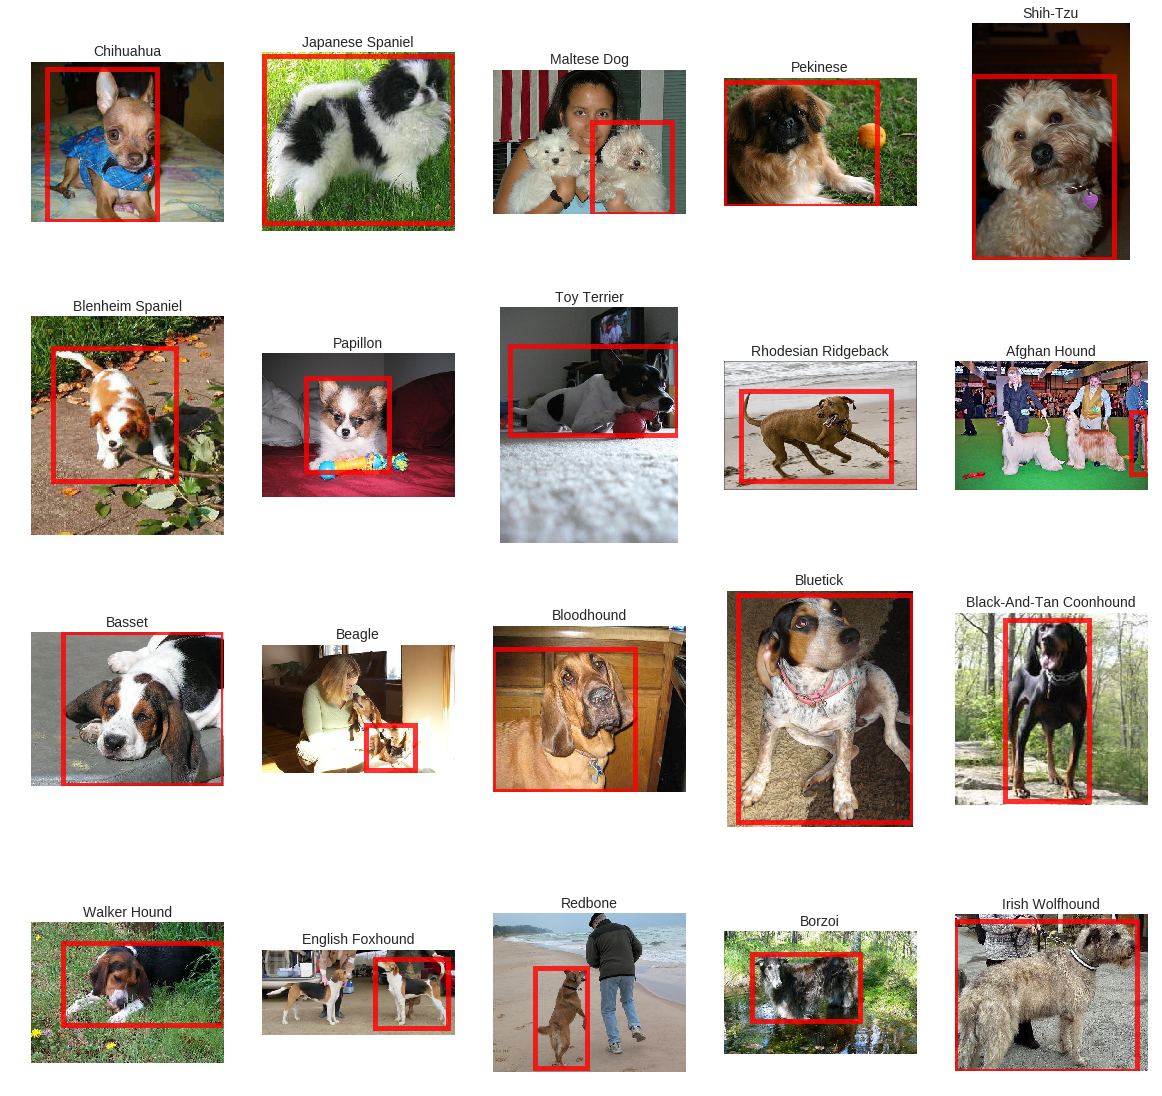

In [0]:
import matplotlib.patches as patches

# Generates a randomly shuffled dataframe
# with one copy of each breed for plotting purposes
train_df_plot = train_df.sample(frac=1, random_state = 42)
train_df_plot = train_df.drop_duplicates(subset="Breed")

# Creates a 4x5 plotting environment
fig, axes = plt.subplots(4,5, figsize=(20,20))
ax = axes.flatten()
counter = 0

# Have to reduce images to the first 20 due to IOPub Rate Limiting
for index, breed in train_df_plot[0:20].iterrows():
    image_data = imageio.imread("Images/" + breed['File'])
    ax[counter].imshow(image_data)
    
    # Generates a bounding box around the dog
    x, y, w, h = generate_bounding_box("Annotation/" + train_df['Annotation'][index])
    rect = patches.Rectangle((x,y), w ,h ,
                             linewidth=5,
                             edgecolor='Red',
                             facecolor='None',
                             fill = False,
                             alpha = .8)

    # Add the patch to the Axes
    ax[counter].add_patch(rect)

    # Set Title
    ax[counter].set_title(breed['Breed'], fontsize=14)
    ax[counter].set_axis_off()
    counter += 1

### 6.2 Visualize First 20 Dog Breeds in Test Set

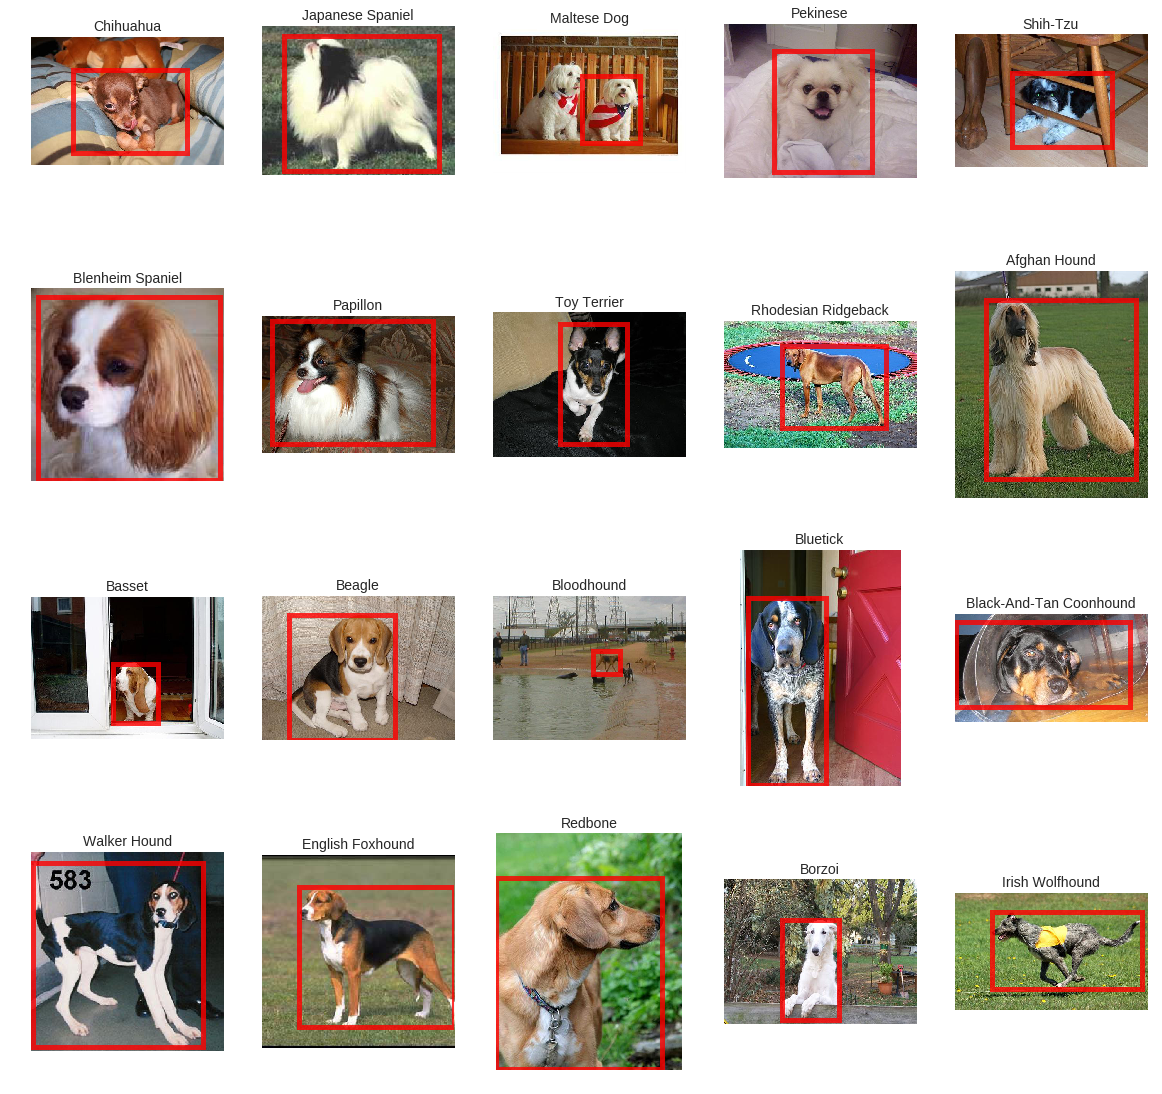

In [0]:
# Generates a randomly shuffled dataframe
# with one copy of each breed for plotting purposes
test_df_plot = test_df.sample(frac=1, random_state = 42)
test_df_plot = test_df.drop_duplicates(subset="Breed")

# Creates a 4x5 plotting environment
fig, axes = plt.subplots(4,5, figsize=(20,20))
ax = axes.flatten()
counter = 0

# Have to reduce images to the first 20 due to IOPub Rate Limiting
for index, breed in test_df_plot[0:20].iterrows():
    image_data = imageio.imread("Images/" + breed['File'])
    ax[counter].imshow(image_data)
    
    # Generates a bounding box around the dog
    x, y, w, h = generate_bounding_box("Annotation/" + test_df['Annotation'][index])
    rect = patches.Rectangle((x,y), w ,h ,
                             linewidth=5,
                             edgecolor='Red',
                             facecolor='None',
                             fill = False,
                             alpha = .8)

    # Add the patch to the Axes
    ax[counter].add_patch(rect)

    # Set Title
    ax[counter].set_title(breed['Breed'], fontsize=14)
    ax[counter].set_axis_off()
    counter += 1

**Comments:**



*   We see that the dogs in the training and test set look vaguely similar to one another.  Perhaps worringly, we see examples of images like the Bloodhound in the test set in which the actual dog is an extremely small component of the image.  Furthermore, many of these images contain photos of two dogs (such as the Bloodhound image and the Maltese dog image), which will be difficult for a naive CNN to pick up on.  
*   Thankfully, the Stanford image dog set provides us with bounding box coordinates to zero in on the actual dog of each image.  We will train our CNN first without the aid of bounding boxes, and select the architecture that performs best in the absence of this information.  Then, for the best CNN, we will using cropped images and see how well our model performs. 



## 7. Generate Sample Images with Filters

In [0]:
from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.exposure import rescale_intensity
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2grey
from skimage import exposure

# Define a helper functions
# http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_adapt_rgb.html
@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)

# Image indices we want to visualize
image_indices = [0, 1000, 2000, 3000, 4000]

# Generate empty list of lists to store transformed images
images = [[] for i in range(len(image_indices))]
grey_scale_transform = [[] for i in range(len(image_indices))]
sobel_transform = [[] for i in range(len(image_indices))]
exposure_equalize_transform = [[] for i in range(len(image_indices))]


# Iterate over all images and apply an illustrative transform
for i, key in enumerate(image_indices):
    images[i] = imread("Images/" + train_df.loc[key].File);
    
    # Process into grey scale for illustrative purposes
    grey_scale_transform[i] = rgb2grey(images[i])
    
    # Sobel's edge detection algorithm 
    sobel_transform[i] = rescale_intensity(1 - sobel_each(images[i]))
    
    # Equalization
    exposure_equalize_transform[i] = exposure.equalize_hist(images[i])

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


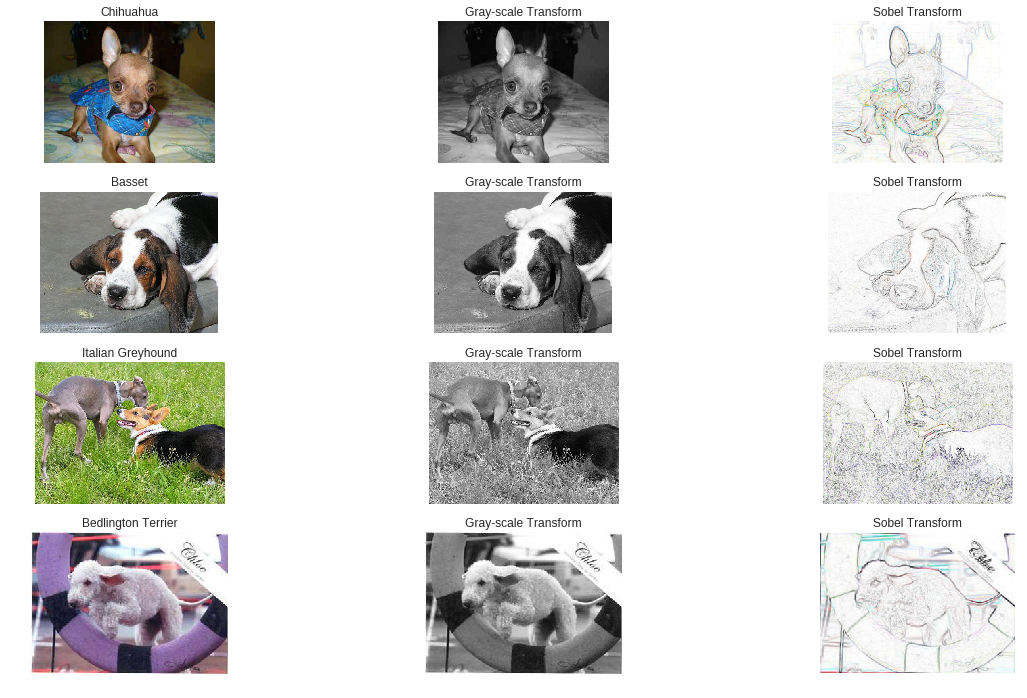

In [0]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12))
counter = 0

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')

    if i % 3 == 0:
        ax.imshow(images[counter])
        ax.set_title(train_df.loc[image_indices[counter]].Breed)
    elif i % 3 == 1:
        ax.imshow(grey_scale_transform[counter], cmap=plt.cm.gray)
        ax.set_title("Gray-scale Transform")
    elif i % 3 == 2:
        ax.imshow(sobel_transform[counter])
        ax.set_title('Sobel Transform')
        counter += 1


**Comments**:

* Here we just flex some of the filters and image transformations available in Scikitlearn. 
* Of particular interest is to note the Sobel Transform which is meant to pick up on edges in our image.  It does this by convolving around an image, multiplying (dot product) a given convolution by a specific kernel matrix 

The specific convolution kernels for a Sobel transform are described below. 

![alt text](https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/sobmasks.gif)

We will see that the first layer of our CNN's produce output very similar to a Sobel Transform, indicating that CNN's naturally pick up on edges from the outset. 

##22. Future Work

In the future, we'd like to explore a huge amount of topics and ideas for improvement we stumbled upon in researching for this project.  


*   As mentioned above, we had a concern that there may be something problematic about cropping both the training and test set images, even though the cropping boundaries were provided in the original dataset.  One potential idea is to train yet another classifier that is given bounding box information of a given image, and train a neural network to estimate a bounding box on a left-out test set.  You would then use these two classifiers in concert with one another -- one classifier would predict a bounding box around the dog and crop the image, and the other classifier would predict on the cropped image.  

*  We wanted to experiment with GANs and other non-CNN networks in order to get our feet wet.  Unfortunately, we couldn't find an application that was actuall suited for the prediction task at hand.  One potential application is the use of GANs to enhance image augmentation, which has been done as recently as [2017](https://arxiv.org/pdf/1801.06665.pdf) on the Stanford Dog dataset

* We would like to, in the future, learn how to generate adverserial examples to force our classifier to misclassify a given image with the addition of some noise.  One interesting goal would be to craft a dog classifier that is robust to adverserial images. 

* It would be interesting to experiment with non CNN techniques, such as SVM's with linear kernels.  We have seen [papers ](https://web.stanford.edu/class/cs231a/prev_projects_2016/output%20[1].pdf)that utilize interesting techniques such as 'facial keypoint detection' to extract key characteristics about dog faces using a CNN before doing SVM analysis. 

